In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filepath = "output.csv"
df = pd.read_csv(filepath, sep=";")

## Correlation test

In [31]:
correlation_matrix = df.corr()
correlation_matrix.iloc[-1][:-1]

sum_of_candidates           0.944030
number_of_initial_values   -0.998791
initial_numbers_entropy    -0.998557
Name: numbers_of_steps_to_solve, dtype: float64

## Plots

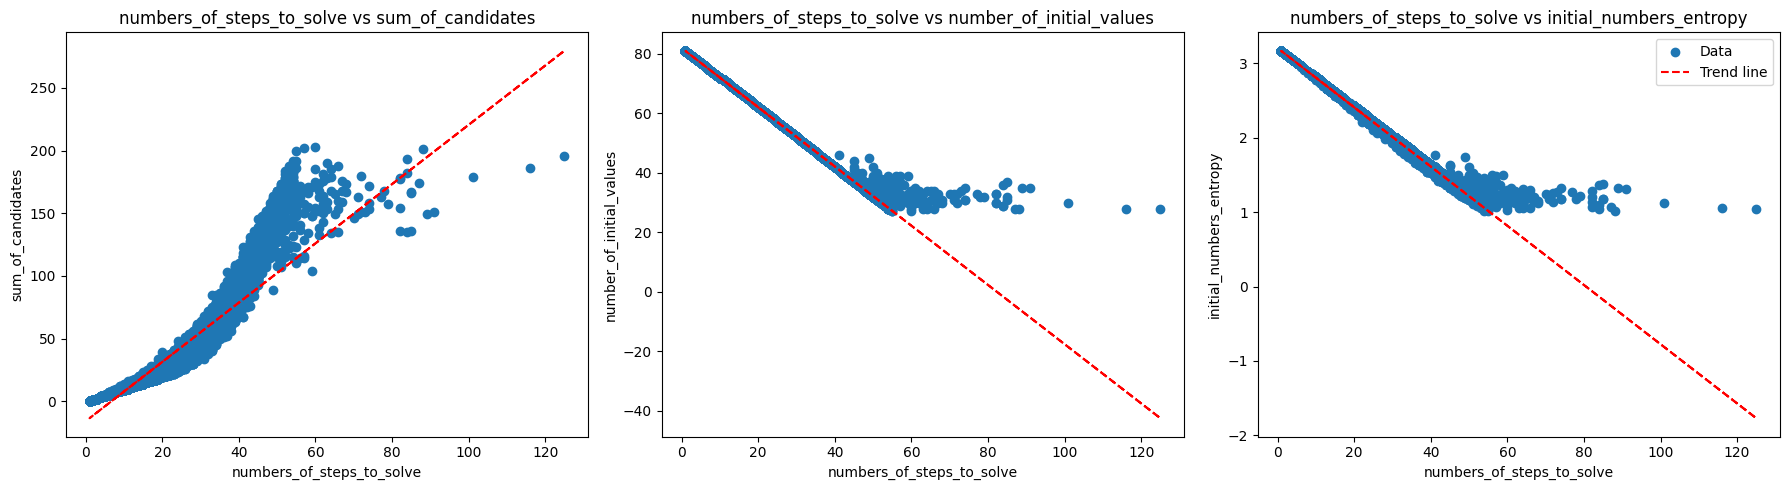

In [32]:
plt.figure(figsize=(18, 5))

# List of column names for plotting
columns = ['sum_of_candidates', 'number_of_initial_values', 'initial_numbers_entropy']

for i, column in enumerate(columns, 1):
    x = df['numbers_of_steps_to_solve']
    y = df[column]
    
    # Scatter plot
    plt.subplot(1, 3, i)
    plt.scatter(x, y, label='Data')
    
    # Fit and plot trend line
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), "r--", label='Trend line')  # "r--" is for red dashed line
    
    plt.title(f'numbers_of_steps_to_solve vs {column}')
    plt.xlabel('numbers_of_steps_to_solve')
    plt.ylabel(column)

plt.tight_layout()
plt.legend()
plt.show()